# Regression Open-Ended Project

------------------

# Define Question / Hypothesis

**Use publicly available data to generate Roger Ebert-esque ratings for recent movies.**

# Obtain Data via Scraping and APIs

- requests - fetch HTML pages
- BeautifulSoup: web scraping
- time: to add in a sleep delay when scraping
- tqdm: a nifty tool to show progress bar
- pandas: for data frames
- pickle: to pickle things

In [19]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import tqdm
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Add Scraping for Infinite Scroll

In [3]:
soup = BeautifulSoup(open('ebert.html'), 'lxml')
all_reviews = soup('figure', {'class':'movie review'})

In [4]:
def scrape_eberts_review(review_set):
    """
    Parses through webpage with list of movies and returns DataFrame.
    :review_set = BeautifulSoup object
    """
    review_list = list()
    
    for movie in review_set:
        url = movie.a.get('href')
        title = movie.find_all('a')[1].text
        stars = len(movie.find_all('i', {'class':'icon-star-full'})) + 0.5 * len(movie.find_all('i', {'class':'icon-star-half'}))
        
        try:
            year = movie.find('span', {'class':'release-year'}).text[1:-1]
        except:
            year = ''

        review_list.append([title, stars, year, url])
    
    df = pd.DataFrame(review_list, columns = ['Title', 'EbertStars', 'Year', 'URL'])
    return df

In [5]:
review_df = scrape_eberts_review(all_reviews)

In [6]:
review_df.head()

,Title,EbertStars,Year,URL
0,Big Little Lies,3.5,2017,http://www.rogerebert.com/reviews/big-little-l...
1,A Cure for Wellness,2.0,2017,http://www.rogerebert.com/reviews/a-cure-for-w...
2,A United Kingdom,2.5,2017,http://www.rogerebert.com/reviews/a-united-kin...
3,Fifty Shades Darker,2.0,2017,http://www.rogerebert.com/reviews/fifty-shades...
4,Kedi,4.0,2017,http://www.rogerebert.com/reviews/kedi-2017


In [7]:
def scrape_webpage(link):
    """
    Parses each individual review page and returns list of key attributes.
    :link = URL for review
    """
    webpage = requests.get(link).text
    soup = BeautifulSoup(webpage, 'lxml')

    try:
        mpaa = soup.find('p', {'class':'mpaa-rating'}).strong.text[6:]
    except:
        mpaa = ''

    try: 
        runningtime = int(soup.find('p', {'class':'running-time'}).strong.text[:3].strip())
    except:
        runningtime = ''

    try:
        genres = soup.find('p', {'class':'genres'}).strong.text.replace(',', '').split()
    except:
        genres = []

    try:
        reviewbody = ' '.join([paragraph.text for paragraph in soup.find('div', {'itemprop':'reviewBody'}).find_all('p')])
    except:
        reviewbody = ''
    
    return [link, mpaa, runningtime, reviewbody]

In [8]:
scraped_list = list()

for movie in tqdm.tqdm(review_df['URL']):
    scraped_list.append(scrape_webpage(movie))
    time.sleep(0.5)

review_content = pd.DataFrame(scraped_list, columns = ['URL', 'Rating', 'Runtime', 'Review'])

100%|██████████| 168/168 [02:04<00:00,  1.31it/s]


In [9]:
review_content.head()

,URL,Rating,Runtime,Review
0,http://www.rogerebert.com/reviews/big-little-l...,NR,420,"HBO’s excellent “Big Little Lies,” based on th..."
1,http://www.rogerebert.com/reviews/a-cure-for-w...,R,146,I keep forgetting the title of “A Cure for Wel...
2,http://www.rogerebert.com/reviews/a-united-kin...,PG-13,111,For a movie about two people who loved each ot...
3,http://www.rogerebert.com/reviews/fifty-shades...,R,118,"Who would have guessed that, when he was a boy..."
4,http://www.rogerebert.com/reviews/kedi-2017,NR,,"The people interviewed for ""Kedi,"" Ceyda Torun..."


In [10]:
pickle.dump(review_df, open('data/review_df.pkl', 'wb'))
pickle.dump(review_content, open('data/review_content.pkl', 'wb'))

In [5]:
review_df = pickle.load(open('data/review_df.pkl', 'rb'))
review_content = pickle.load(open('data/review_content.pkl', 'rb'))

In [6]:
combined_df = pd.merge(review_df, review_content, how='left', on='URL')

In [7]:
combined_df.head()

,Title,EbertStars,Year,URL,Rating,Runtime,Review
0,A Cure for Wellness,2.0,2017,/reviews/a-cure-for-wellness-2017,NaN,NaN,NaN
1,Big Little Lies,3.5,2017,/reviews/big-little-lies-2017,NaN,NaN,NaN
2,The Great Wall,3.0,2017,/reviews/the-great-wall-2017,NaN,NaN,NaN
3,American Fable,3.0,2017,/reviews/american-fable-2017,NaN,NaN,NaN
4,Lovesong,3.0,2017,/reviews/lovesong-2017,NaN,NaN,NaN


# Process and Clean Data

- identify types of variables

Features from IMDB - [IMDB.py](http://imdbpy.sourceforge.net/)
- genres
- rating
- number of votes
- country
- awards
- metascore
- number of reviews (user / critic)

In [8]:
df_rating = pd.get_dummies(combined_df['Rating'])

In [9]:
new_df = pd.concat([combined_df, df_rating], axis=1)

In [10]:
new_df.head()

,Title,EbertStars,Year,URL,Rating,Runtime,Review
0,A Cure for Wellness,2.0,2017,/reviews/a-cure-for-wellness-2017,NaN,NaN,NaN
1,Big Little Lies,3.5,2017,/reviews/big-little-lies-2017,NaN,NaN,NaN
2,The Great Wall,3.0,2017,/reviews/the-great-wall-2017,NaN,NaN,NaN
3,American Fable,3.0,2017,/reviews/american-fable-2017,NaN,NaN,NaN
4,Lovesong,3.0,2017,/reviews/lovesong-2017,NaN,NaN,NaN


In [11]:
def convert_year(row):
    try:
        year = int(row['Year'])
        return year
    except:
        pass
    
def convert_runtime(row):
    try:
        runtime = int(row['Runtime'])
        return runtime
    except:
        pass

In [12]:
new_df['year'] = new_df.apply(lambda x: convert_year(x), 1)

In [13]:
new_df['runtime'] = new_df.apply(lambda x: convert_runtime(x), 1)

In [14]:
new_df.dtypes

Title          object
EbertStars    float64
Year           object
URL            object
Rating         object
Runtime        object
Review         object
year          float64
runtime        object
dtype: object

In [15]:
new_df.EbertStars.mode()

0    3.0
dtype: float64

# Feature Engineering

# Database

# EDA

In [16]:
new_df.head()

,Title,EbertStars,Year,URL,Rating,Runtime,Review,year,runtime
0,A Cure for Wellness,2.0,2017,/reviews/a-cure-for-wellness-2017,NaN,NaN,NaN,2017.0,None
1,Big Little Lies,3.5,2017,/reviews/big-little-lies-2017,NaN,NaN,NaN,2017.0,None
2,The Great Wall,3.0,2017,/reviews/the-great-wall-2017,NaN,NaN,NaN,2017.0,None
3,American Fable,3.0,2017,/reviews/american-fable-2017,NaN,NaN,NaN,2017.0,None
4,Lovesong,3.0,2017,/reviews/lovesong-2017,NaN,NaN,NaN,2017.0,None


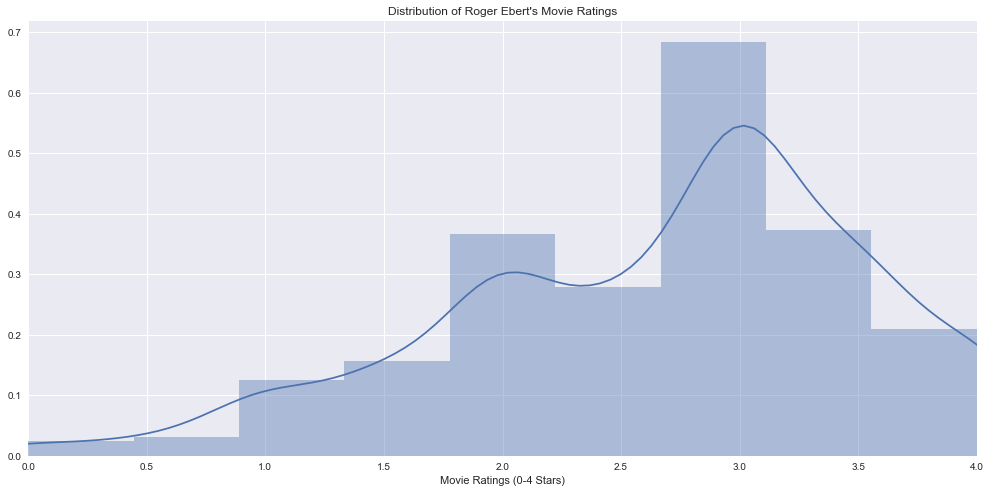

In [63]:
plt.figure(figsize=(17,8))
ax = sns.distplot(new_df['EbertStars'], bins=9, kde_kws={"bw": 0.25}, 
                  axlabel='Movie Ratings (0-4 Stars)')
ax.set(xlim=(0, 4))
ax.set_title("Distribution of Roger Ebert's Movie Ratings")

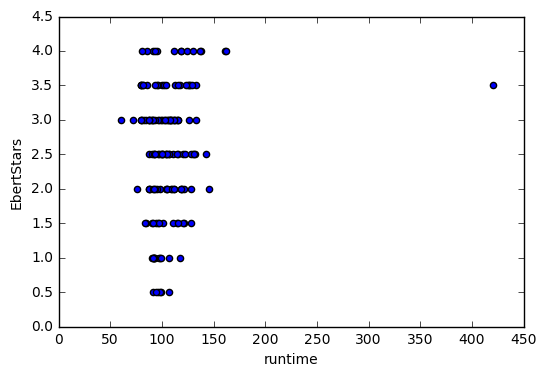

In [23]:
new_df.plot.scatter(x='runtime', y='EbertStars')

In [24]:
new_df = new_df[new_df['runtime'] < 250]

In [25]:
new_df.Rating.value_counts()

R        50
NR       48
PG-13    30
         17
PG        6
G         1
Name: Rating, dtype: int64

In [26]:
new_df = new_df.rename(columns={'PG-13': 'PG_13'})

# Modeling


In [27]:
import statsmodels.formula.api as smf
import numpy as np

In [28]:
model_df = new_df[['runtime', 'G', 'NR', 'PG', 'PG_13','R','EbertStars']]

In [29]:
model_df.corr()

,runtime,G,NR,PG,PG_13,R,EbertStars
runtime,1.000000,-0.081251,-0.343071,-0.032473,0.252139,0.210774,0.164540
G,-0.081251,1.000000,-0.055286,-0.016497,-0.040355,-0.056977,0.040496
NR,-0.343071,-0.055286,1.000000,-0.137722,-0.336887,-0.475651,0.079921
PG,-0.032473,-0.016497,-0.137722,1.000000,-0.100526,-0.141933,-0.007870
PG_13,0.252139,-0.040355,-0.336887,-0.100526,1.000000,-0.347189,-0.019251
R,0.210774,-0.056977,-0.475651,-0.141933,-0.347189,1.000000,-0.177414
EbertStars,0.164540,0.040496,0.079921,-0.007870,-0.019251,-0.177414,1.000000


In [30]:
model = smf.ols(formula='EbertStars ~ runtime + G + NR + PG + PG_13 + R', data=model_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EbertStars   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3.133
Date:                Fri, 17 Feb 2017   Prob (F-statistic):            0.00644
Time:                        16:14:20   Log-Likelihood:                -195.72
No. Observations:                 152   AIC:                             405.4
Df Residuals:                     145   BIC:                             426.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.4648      0.517      2.834      0.005         0.443     2.486
runtime        0.0151      0.005      3.212      0.002         0.006     0.024
G              0.2244      0.926      0.242      0.809        -1.606     2.054
NR            -0.2569      0.254     -1.010      0.314        -0.759     0.246
PG            -0.4916      0.426     -1.153      0.251        -1.334     0.351
PG_13         -0.6638      0.279     -2.378      0.019        -1.216    -0.112
R             -0.8104      0.256     -3.168      0.002        -1.316    -0.305
==============================================================================
Omnibus:                        8.479   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                4.505
Skew:                          -0.207   Prob(JB):                        0.105
Kurtosis:                       2.266   Cond. No.                     1.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
def half_round(x, prec=1, base=.5):
    return round(base * round(float(x) / base), prec)

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(model_df, test_size=0.33, random_state=42)

In [33]:
model = smf.ols(formula='EbertStars ~ runtime + G + NR + PG + PG_13 + R', data=train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EbertStars   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3.364
Date:                Fri, 17 Feb 2017   Prob (F-statistic):            0.00477
Time:                        16:14:20   Log-Likelihood:                -123.12
No. Observations:                 101   AIC:                             260.2
Df Residuals:                      94   BIC:                             278.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.3472      0.557      2.418      0.018         0.241     2.453
runtime        0.0159      0.005      3.108      0.002         0.006     0.026
G              0.2671      0.881      0.303      0.762        -1.482     2.016
NR            -0.0450      0.282     -0.160      0.873        -0.605     0.515
PG            -0.4718      0.481     -0.980      0.330        -1.428     0.484
PG_13         -0.7268      0.299     -2.427      0.017        -1.321    -0.132
R             -0.8160      0.273     -2.988      0.004        -1.358    -0.274
==============================================================================
Omnibus:                        5.982   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                2.957
Skew:                          -0.143   Prob(JB):                        0.228
Kurtosis:                       2.212   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
results.params

Intercept    1.347174
runtime      0.015928
G            0.267112
NR          -0.045026
PG          -0.471804
PG_13       -0.726775
R           -0.815965
dtype: float64

In [35]:
coefficients = results.params

In [36]:
test.insert(0, 'intercept', 1)

In [37]:
y_true = test['EbertStars']
y_pred = np.dot(test.drop('EbertStars', 1), coefficients)

In [38]:
# baseline
baseline = [3.0] * len(y_true)

In [39]:
from sklearn.metrics import mean_squared_error

baseline_error = mean_squared_error(y_true, baseline)
print('Baseline Algorithm Error: ', baseline_error)

Baseline Algorithm Error:  1.21568627451


In [40]:
y_pred_round = [half_round(y) for y in y_pred]

In [41]:
model_error = mean_squared_error(y_true, y_pred_round)
print('Linear Regression Error: ', model_error)

Linear Regression Error:  1.08823529412


# Visuals

# Conclusions, Lessons Learned and Further Research